In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs
import pandas as pd

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, featureExtraction, createFilterBank,
                                                testWindowLength, testClassifier, testFrequencyBand,
                                                testWindowStartTime,testWindowStartTime_Length, startRunningClassifier)


In [2]:
dataB = scipy.io.loadmat("BCICIV_1_mat/BCICIV_calib_ds1b.mat")

dataB["cnt"] = 0.1 * dataB["cnt"].astype(float)

eeg = dataB["cnt"].T 
nChannels, nSamples = eeg.shape

calibDataStore, testData_motionIntent, _, comp = featureExtraction(dataB,0.7)

calibData_idle_motionIntent, testData_idle_motionIntent, W_idle_motionIntent , comp = featureExtraction(dataB,0.7,ExtractionType="idle_motionIntent")



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Base Classifiers for detecting Idle State

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score


ldaModel = LDA()
SVMmodel = SVC(probability=True,class_weight="balanced") 
logRegModel = LogisticRegression(class_weight="balanced")


In [4]:
nCols = len(calibData_idle_motionIntent.columns)


print("LDA: ",np.mean(cross_val_score(ldaModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print()


LDA:  0.8678571428571429
Logistic Regression:  0.8535714285714284
SVM:  0.85



In [5]:
print("Performance on test data - Untuned models")
print()
#Do not use crossValidtation on test data
for model in [ldaModel,SVMmodel,logRegModel]:
    print(type(model).__name__)
    print("----------------")
    #cross val score does not fit mode hence, the need to fit the model on the training data
    model.fit(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1])
    print(f"{np.mean(accuracy_score(model.predict(testData_idle_motionIntent.iloc[:,:nCols-1]), testData_idle_motionIntent.iloc[:,nCols-1]))}")
    print()


Performance on test data - Untuned models

LinearDiscriminantAnalysis
----------------
0.85

SVC
----------------
0.8916666666666667

LogisticRegression
----------------
0.8666666666666667



### Tuning Classifiers for detecting Idle State

In [6]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [7]:
print("LDA - Tuned")
print("-------")

#  Set the parameter grid for grid search
param_grid = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': np.arange(0,1,0.1)}

# Create the grid search object
gridLDA = GridSearchCV(estimator=LDA(), param_grid=param_grid,scoring="accuracy", cv=5)

# Fit the grid search model to the data
gridLDA.fit(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1])

# Get the best hyperparameters
#print(gridLDA.best_params_)

# Get the best score
print(f"{gridLDA.best_score_}")
print()

    


LDA - Tuned
-------
0.8678571428571429



In [8]:
print("Logistic Regression -  Tuned")
print("-------------------")

#Set the parameter grid for grid search
param_grid = {'penalty': ['l1','l2'], 'C':list(np.logspace(-3,3)), 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

# Create the grid search object
gridLogReg = GridSearchCV(estimator=LogisticRegression(class_weight="balanced"), param_grid=param_grid,scoring='accuracy', cv=5)#Change class weights back to balanced

# Fit the grid search to the data
gridLogReg.fit(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1])

# Get the best hyperparameters
#print(gridLogReg.best_params_)

# Get the best score
print(f"{gridLogReg.best_score_}")
print()



Logistic Regression -  Tuned
-------------------
0.8785714285714284



In [9]:
print("SVM")
print("-------")

#Set the parameter grid for grid search
param_grid = {'C': [0.0001,0.001,0.01,1,10,100,1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel':["rbf","linear"]}

# Create the grid search object
gridSVM = GridSearchCV(estimator=SVC(probability=True,class_weight="balanced"), param_grid=param_grid,scoring="accuracy", cv=5)

# Fit the grid search to the data
gridSVM.fit(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1])

# Get the best hyperparameters
#print(gridSVM.best_params_)

# Get the best score
print(f"{gridSVM.best_score_}")
print()


SVM
-------
0.8571428571428571



In [10]:
print("Performance on test data - Tuned Models")
for model in [gridLDA.best_estimator_,gridLogReg.best_estimator_,gridSVM.best_estimator_]:
    print(type(model).__name__)
    print("----------------")
   
    print(f"{np.mean(accuracy_score(model.predict(testData_idle_motionIntent.iloc[:,:nCols-1]), testData_idle_motionIntent.iloc[:,nCols-1]))}")
    print()


Performance on test data - Tuned Models
LinearDiscriminantAnalysis
----------------
0.85

LogisticRegression
----------------
0.8583333333333333

SVC
----------------
0.8583333333333333



In [11]:
idlesStateClassifier = gridLogReg.best_estimator_

In [12]:
idlesStateClassifier

LogisticRegression(C=0.3727593720314938, class_weight='balanced',
                   solver='liblinear')

### Base Classifier for classifying motion intent signals

In [13]:

ldaModel = LDA()
SVMmodel = SVC(probability=True, class_weight="balanced") #Change class weights back to balanced if necessary
logRegModel = LogisticRegression(class_weight="balanced") #Change class weights back to balanced


In [14]:
for name, calibData in calibDataStore.items():

    nCols = len(calibData.columns)
    print(name,end="\n")
    print("-----------")

    print("LDA: ",np.mean(cross_val_score(ldaModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print()


RO
-----------
LDA:  0.7967980295566501
Logistic Regression:  0.7967980295566501
SVM:  0.7970443349753694

SMOTE
-----------
LDA:  0.7967980295566501
Logistic Regression:  0.7899014778325123
SVM:  0.7899014778325123

RU
-----------
LDA:  0.7978835978835979
Logistic Regression:  0.7904761904761904
SVM:  0.791005291005291

CC
-----------
LDA:  0.7904761904761904
Logistic Regression:  0.7976190476190476
SVM:  0.7690476190476191

None
-----------
LDA:  0.7857142857142857
Logistic Regression:  0.8071428571428572
SVM:  0.7857142857142857



In [15]:
print("Performance on test data - Untuned models")
print()
#Do not use crossValidtation on test data
for model in [ldaModel,SVMmodel,logRegModel]:
    print(type(model).__name__)
    print("----------------")
    for name, calibData in calibDataStore.items():
        #cross val score does not fit mode hence, the need to fit the model on the training data
        nCols = len(calibData.columns)
        model.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])
        print(f"{name} = {np.mean(accuracy_score(model.predict(testData_motionIntent.iloc[:,:nCols-1]), testData_motionIntent.iloc[:,nCols-1]))}")
    print()


Performance on test data - Untuned models

LinearDiscriminantAnalysis
----------------
RO = 0.8833333333333333
SMOTE = 0.9
RU = 0.8833333333333333
CC = 0.8833333333333333
None = 0.8833333333333333

SVC
----------------
RO = 0.8833333333333333
SMOTE = 0.8833333333333333
RU = 0.8833333333333333
CC = 0.8833333333333333
None = 0.8833333333333333

LogisticRegression
----------------
RO = 0.8833333333333333
SMOTE = 0.9
RU = 0.8833333333333333
CC = 0.8833333333333333
None = 0.8833333333333333



### Tuned Classification

In [16]:
print("LDA - Tuned")
print("-------")
best_LDA_resamp_estimator = None
for name, calibData in calibDataStore.items():

    #  Set the parameter grid for grid search
    param_grid = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': np.arange(0,1,0.1)}

    # Create the grid search object
    gridLDA = GridSearchCV(estimator=LDA(), param_grid=param_grid,scoring="accuracy", cv=5)

    # Fit the grid search model to the data
    gridLDA.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])

    # Get the best hyperparameters
    #print(gridLDA.best_params_)

    # Get the best score
    print(f"{name} {gridLDA.best_score_}")
    print()

    if not best_LDA_resamp_estimator:
        best_LDA_resamp_estimator = (gridLDA.best_estimator_,gridLDA.best_score_)

    elif gridLDA.best_score_ > best_LDA_resamp_estimator[1]:
        best_LDA_resamp_estimator = (gridLDA.best_estimator_,gridLDA.best_score_)



LDA - Tuned
-------
RO 0.7967980295566501

SMOTE 0.8108374384236454

RU 0.7978835978835979

CC 0.7904761904761904

None 0.7857142857142857



In [17]:
print("Logistic Regression -  Tuned")
print("-------------------")
best_logReg_resamp_estimator = None
for name, calibData in calibDataStore.items():

    #Set the parameter grid for grid search
    param_grid = {'penalty': ['l1','l2'], 'C':list(np.logspace(-3,3)), 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

    # Create the grid search object
    gridLogReg = GridSearchCV(estimator=LogisticRegression(class_weight="balanced"), param_grid=param_grid,scoring='accuracy', cv=5)#Change class weights back to balanced

    # Fit the grid search to the data
    gridLogReg.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])

    # Get the best hyperparameters
    #print(gridLogReg.best_params_)

    # Get the best score
    print(f"{name} {gridLogReg.best_score_}")
    print()

    if not best_logReg_resamp_estimator:
        best_logReg_resamp_estimator = (gridLogReg.best_estimator_, gridLogReg.best_score_)

    elif gridLogReg.best_score_ > best_logReg_resamp_estimator[1]:
        best_logReg_resamp_estimator = (gridLogReg.best_estimator_, gridLogReg.best_score_)


Logistic Regression -  Tuned
-------------------
RO 0.8179802955665025

SMOTE 0.8179802955665025

RU 0.7978835978835979

CC 0.8052910052910052

None 0.8142857142857143



In [18]:
print("SVM")
print("----")
best_SVM_resamp_estimator = None
for name, calibData in calibDataStore.items():

    #Set the parameter grid for grid search
    param_grid = {'C': [0.0001,0.001,0.01,1,10,100,1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel':["rbf","linear"]}

    # Create the grid search object
    gridSVM = GridSearchCV(estimator=SVC(probability=True,class_weight="balanced"), param_grid=param_grid,scoring="accuracy", cv=5) #Change class weights back to balanced ?

    # Fit the grid search to the data
    gridSVM.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])

    # Get the best hyperparameters
    #print(gridSVM.best_params_)

    # Get the best score
    print(f"{name} {gridSVM.best_score_}")
    print()

    if not best_SVM_resamp_estimator:
        best_SVM_resamp_estimator = (gridSVM.best_estimator_,gridSVM.best_score_)
        
    elif gridSVM.best_score_ > best_SVM_resamp_estimator[1]:
        best_SVM_resamp_estimator = (gridSVM.best_estimator_,gridSVM.best_score_)



SVM
----
RO 0.8322660098522168

SMOTE 0.8253694581280788

RU 0.8124338624338623

CC 0.791005291005291

None 0.8142857142857144



In [19]:
print("Performance on test data - Tuned Models")
for model in [best_LDA_resamp_estimator[0],best_SVM_resamp_estimator[0],best_logReg_resamp_estimator[0]]:
    print(type(model).__name__)
    print("----------------")
    for name, calibData in calibDataStore.items():
        #model has already been fit
        print(f"{name} = {np.mean(accuracy_score(model.predict(testData_motionIntent.iloc[:,:nCols-1]), testData_motionIntent.iloc[:,nCols-1]))}")
    print()


Performance on test data - Tuned Models
LinearDiscriminantAnalysis
----------------
RO = 0.8833333333333333
SMOTE = 0.8833333333333333
RU = 0.8833333333333333
CC = 0.8833333333333333
None = 0.8833333333333333

SVC
----------------
RO = 0.9
SMOTE = 0.9
RU = 0.9
CC = 0.9
None = 0.9

LogisticRegression
----------------
RO = 0.9
SMOTE = 0.9
RU = 0.9
CC = 0.9
None = 0.9



### Window Length test

### Accuracy

In [20]:
# _, _ = testWindowLength(dataB,
#                 ["Logistic Regression","LDA","SVC"],
#                 0.7)

### Window Start time test

### Accuracy

In [21]:
# bestEstimator_start_time, W_start_time = testWindowStartTime(dataB,
#                     ["Logistic Regression","LDA","SVC"],
#                     0.7,
#                     4.5)


###Test all combinations of window start and length?

Above I tested window start time and window length independently. I will now test the combinations of all the above window start times and lengths
together.

In [22]:
# bestEstimator_start_length_combo, W_start_Length_combo = testWindowStartTime_Length(dataB,
#                                                                                     ["Logistic Regression","LDA","SVC"],
#                                                                                     0.7)


In [23]:
# bestEstimator_start_length_combo

#Test effect of varying window start 

### Investigating the effect of varying the frquency band (for each resampling technique)

In [24]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataB,nSamples)

filterBank = createFilterBank(sRate)

freqBandEstimators = {}

In [25]:
calibDataStore.keys()

dict_keys(['RO', 'SMOTE', 'RU', 'CC', 'None'])

In [26]:
#Populate a dictionary with frequency band estimators for each resampling technique

for resamplerType in calibDataStore.keys():
    print(resamplerType)
    print("------------")
    bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band = testFrequencyBand(dataB,
                                                                                         ["Logistic Regression","LDA","SVC"],
                                                                                         filterBank,
                                                                                         0.7,
                                                                                         trialWinStart=0,
                                                                                         trialWinEnd = 4,
                                                                                         resampler=resamplerType)
    
    print()

    freqBandEstimators[resamplerType] = (bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band)


RO
------------
8-12 : 0.8322660098522168
8-15 : 0.8527093596059112
13-30 : 0.8243842364532019

SMOTE
------------
8-12 : 0.8253694581280788
8-15 : 0.8527093596059112
13-30 : 0.8241379310344827

RU
------------
8-12 : 0.8124338624338623
8-15 : 0.8481481481481481
13-30 : 0.8481481481481481

CC
------------
8-12 : 0.8052910052910052
8-15 : 0.8481481481481481
13-30 : 0.8264550264550264

None
------------
8-12 : 0.8142857142857144
8-15 : 0.85
13-30 : 0.8214285714285715



In [27]:
freqBandEstimators.keys()

dict_keys(['RO', 'SMOTE', 'RU', 'CC', 'None'])

RO resampler optimal threshold : 0.666960155226422
SMOTE resampler optimal threshold : 0.44829141833111713
RU resampler optimal threshold : 0.7057918267473047
CC resampler optimal threshold : 0.7014722311114049
None resampler optimal threshold : 0.6484724888204154


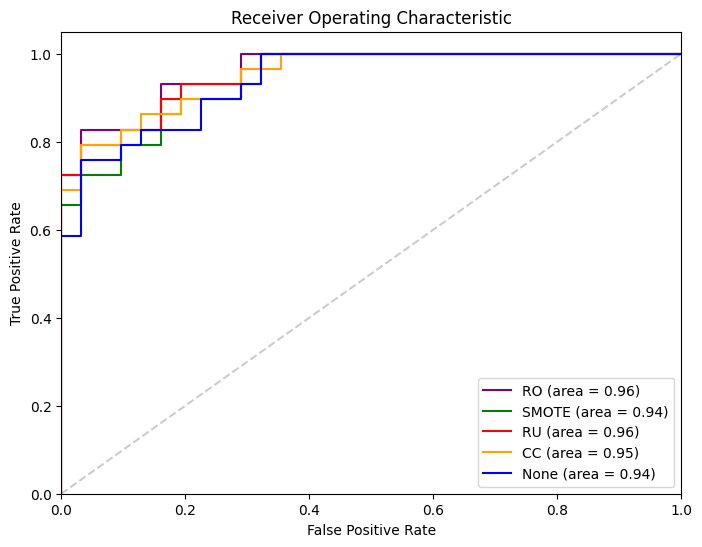

In [28]:
plt.figure(figsize=(8, 6))
colour_idx = 0 
colours = ['purple', 'green', 'red','orange','blue']

for name, (best_band,estimator, filter_b_a, best_W) in freqBandEstimators.items():
    probs = cross_val_predict(estimator, testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1], cv=5, method="predict_proba")
    probs = probs[:, 1]  # use the probability of the positive class
    true_labels = testData_motionIntent.iloc[:,nCols-1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(true_labels, probs)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve for current model
    plt.plot(fpr, tpr, color=colours[colour_idx], label= name + ' (area = %0.2f)' % auc_score)
    colour_idx += 1

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"{name} resampler optimal threshold : {optimal_threshold}")

plt.plot([0, 1], [0, 1], 'k--',alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Calibration of best classifier to predict probability outputs for all time samples

In [29]:
evalDataB = scipy.io.loadmat("BCICIV_1_mat/BCICIV_eval_ds1b.mat")

In [30]:
_, bestEstimator_freq_band, (best_b,best_a), W_freq_band = freqBandEstimators["RO"]


In [31]:
bestEstimator_freq_band

LogisticRegression(C=2.6826957952797246, class_weight='balanced',
                   solver='newton-cg')

In [32]:
idlesStateClassifier

LogisticRegression(C=0.3727593720314938, class_weight='balanced',
                   solver='liblinear')

In [33]:
import sklearn
from sklearn.calibration import CalibratedClassifierCV


bestEstimator_freq_band = CalibratedClassifierCV(bestEstimator_freq_band,cv="prefit")
bestEstimator_freq_band.fit(calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1])

CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=2.6826957952797246,
                                                    class_weight='balanced',
                                                    solver='newton-cg'))

#### Calibrate SVC

In [34]:
probabilities = startRunningClassifier(evalDataB,bestEstimator_freq_band,idlesStateClassifier,comp,W_freq_band,W_idle_motionIntent,trialWinStart=0,trialWinEnd=4,b=best_b,a=best_a)


In [35]:
len(probabilities)

246571

In [36]:
import csv

with open("output_subject_b_original_timeWin_100Hz.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)


In [30]:
bestEstimator_freq_band.classes_

array([-1,  1])

### Person's Correlation Coefficient (PCC) + CSP

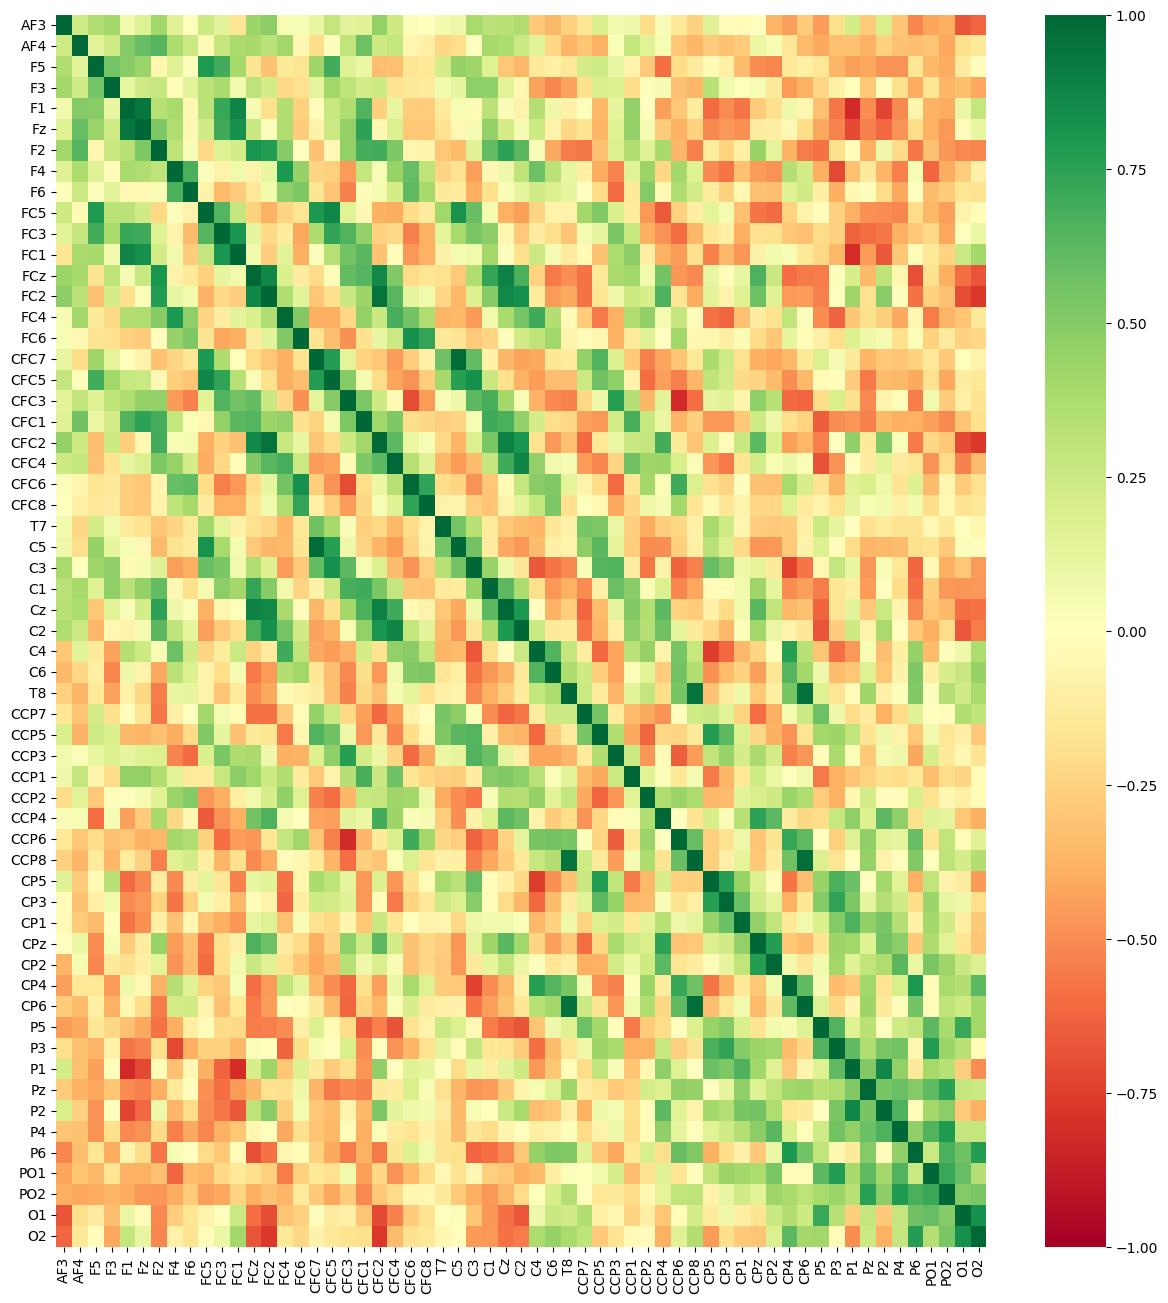

In [17]:
#Plot distributions of channels against eachother
# to find out if there is any sort of positive correlation
# between channels

trialWin = np.arange(int(0.5*sRate),int(2.5*sRate))

# #get mixed trial data from original
trials_mixed = np.zeros(
            (nChannels, len(eventOnsets[0]), len(trialWin)))


for i, onset in enumerate(eventOnsets[0]):
    trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# we can able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.

from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

scaler = StandardScaler()

# For each trial
#We must standardize the values in each trial window for each channel (We use z-score normalization for this) 
_, nTrials, _ = trials_mixed.shape

trialChannelCorrelations = []

plotFirst = False #flag to check that heatmap of first trial is plotted 

for trial in range(nTrials):
 
    zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
    corrMat = np.corrcoef(zTrial)

    if not plotFirst:
        plt.figure(figsize=(15, 16))
        sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
        plotFirst = True
    
#     # We must then calculate the correlation matrices for each trial and return the mean for each row, giving us a vector of mean values
#     # which represents the average corellation values for a specific channel in relation to other channels.
    channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

#     #Following the above referenced paper, we select the first 14 channels

    channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
    trialChannelCorrelations.append(channelCorrValues)
    

<AxesSubplot: >

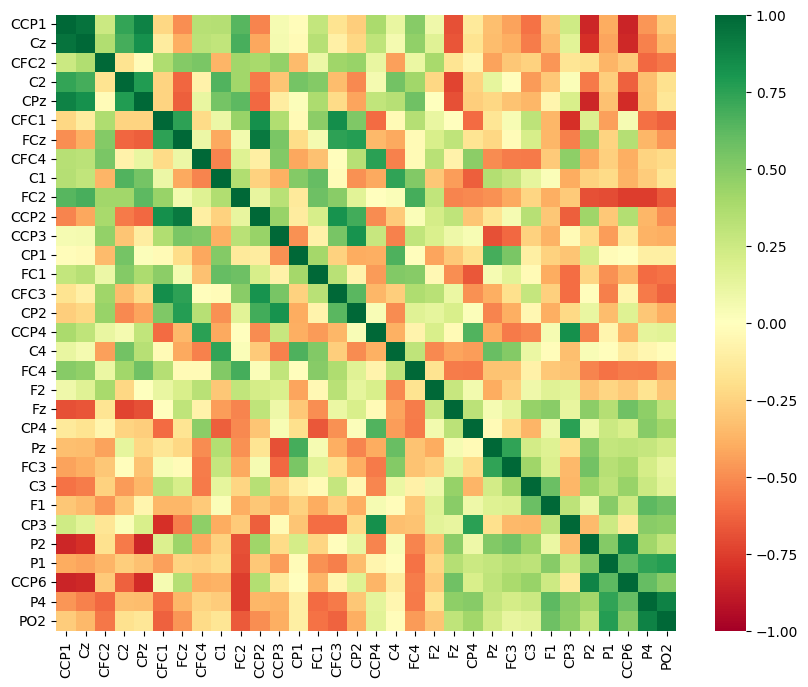

In [18]:
from collections import defaultdict

channelOccurences = defaultdict(int)

for dic in trialChannelCorrelations:
    for ch, _ in dic.items():
        channelOccurences[ch] += 1


# This represent the most correlated channels ordered (descending) by the number of time they appear
# in the most correlated channel list for each trial
channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

selectedChannels = list(channelOccurences.keys())[:32]
# #It can be seen that all selected channels are in and around the sensorimotor cortex

selectedSet = set(selectedChannels)
selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

# #Plot heatmap of first trial
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
            columns=selectedChannels,
            index=selectedChannels),
            cmap="RdYlGn",
            vmin=-1,
            vmax=1)

# We can clearly see a positive correleation between some channels measuring along the same
# hemisphere on the motor strip e.g CFC1 and CCP1, and negative correleation between channels
# that are at approximately opposite hemishperes on the motor strip e.g C1 and C2
# While not all correlations fall in line (C1 and C3 having a negative correlation), some of the findings in
# this plot give credence to the theory of contralateral activation and supression for left and right hand motor imagery signals


In [19]:
accVal = 0
bestAccVal = 0
bestEstimator_selected_channels = None
for model in ["Logistic Regression","LDA","SVC"]:
    accVal, estimator, W_channelSelect =  testClassifier(dataB,0.5,2.5,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs,resampler="None")
    print(f"acc val for {model} is {accVal}")
    if accVal > bestAccVal:
        bestAccVal = accVal
        bestEstimator_selected_channels = estimator
    
bestAccVal

acc val for Logistic Regression is 0.7785714285714287
acc val for LDA is 0.7571428571428572
acc val for SVC is 0.7642857142857143


0.7785714285714287

In [20]:
bestEstimator_selected_channels

LogisticRegression(C=0.029470517025518096, solver='liblinear')

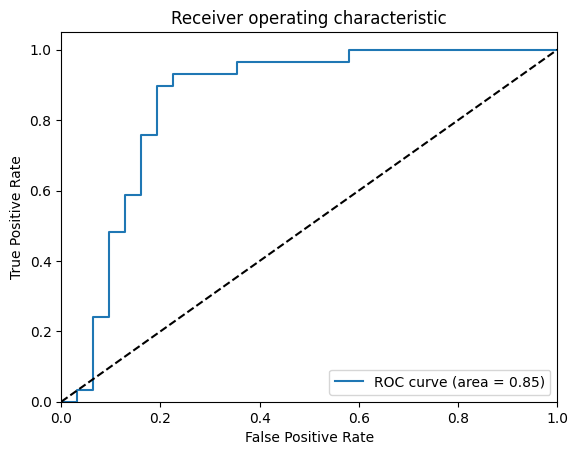

In [21]:
probs = cross_val_predict(bestEstimator_selected_channels,testData.iloc[:,:nCols-1], testData.iloc[:,nCols-1],cv=5, method="predict_proba")
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [33]:
channelNums = dict()

for i in range(2,nChannels+1):
    selectedChannels = list(channelOccurences.keys())[:i]
    # #It can be seen that all selected channels are in and around the sensorimotor cortex

    selectedSet = set(selectedChannels)
    selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

    accVal = 0
    bestAccVal = 0
    bestEstimator_selected_channels = None
    for model in ["Logistic Regression","LDA","SVC"]:
        accVal, estimator, W =  testClassifier(dataB,0.5,2.5,1,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)
        
        if accVal > bestAccVal:
            bestAccVal = accVal
            bestEstimator_selected_channels = estimator

    channelNums[i] = bestAccVal




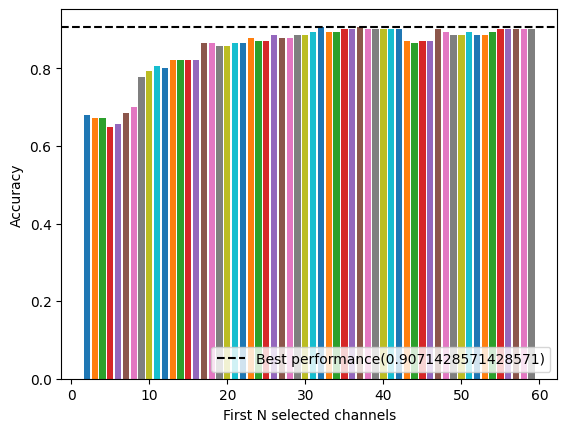

In [ ]:
bestY = 0
for x, y in channelNums.items():
    bestY= max(bestY,y)
    plt.bar(x,y)

plt.xlabel("First N selected channels")
plt.ylabel("Accuracy")
plt.axhline(y=bestY, color='black', ls='--', lw=1.5, label=f"Best performance({bestY})")
plt.legend(loc='lower right')
